In [2]:
from skimage.io import imread
import matplotlib.pyplot as plt
img = imread("C:/Users/stan2/Documents/4A/Comp Imaging/MinCut-MaxFlow/dataset/images/65019.jpg")
img_gt = imread("C:/Users/stan2/Documents/4A/Comp Imaging/MinCut-MaxFlow/dataset/images-gt/65019.png")

img_label = imread("C:/Users/stan2/Documents/4A/Comp Imaging/MinCut-MaxFlow/dataset/images-labels/65019-anno.png")


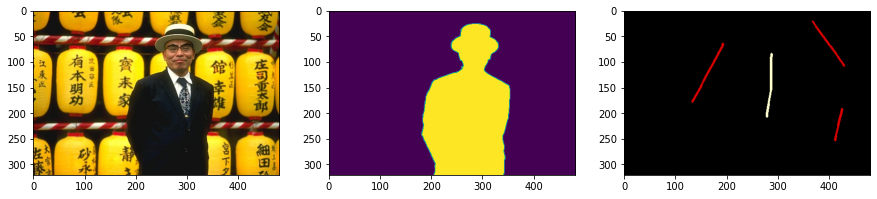

In [3]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(131)
ax1.imshow(img)
ax2 = fig.add_subplot(132)
ax2.imshow(img_gt)
ax3 = fig.add_subplot(133)
ax3.imshow(img_label)

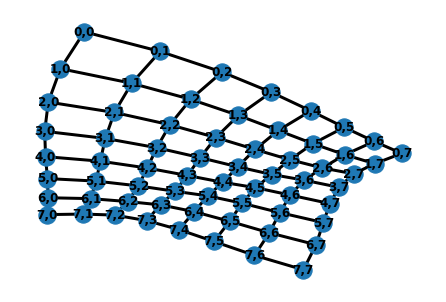

In [218]:
import networkx as nx
import random
from math import *
G = nx.Graph()
nbx = 8
nby = 8
nodes = [str(i)+","+str(j) for i in range(nbx) for j in range(nby)]
G.add_nodes_from(nodes, terminal = None, parent = None)
G.add_weighted_edges_from([(str(i)+","+str(j),str(i+1)+","+str(j),exp(abs(i+j-nbx)/nbx)) for i in range(nbx-1) for j in range(nby)])
G.add_weighted_edges_from([(str(i)+","+str(j),str(i)+","+str(j+1),exp(abs(i+j-nbx)/nby)) for i in range(nbx) for j in range(nby-1)])
nx.set_edge_attributes(G, 'black', "color")
nx.draw_kamada_kawai(G, edge_color = nx.get_edge_attributes(G,'color').values(), width=3, with_labels=True, font_weight='bold')

In [219]:
def grow(Graph, Active):
    while len(Active)>0:
        node_name = Active.pop()
        node = Graph.nodes[node_name]
        for neighbor_name in Graph[node_name]:
            neighbor = Graph.nodes[neighbor_name]
            if not neighbor['terminal']:
                Active.insert(0,neighbor_name)
                neighbor['terminal'] = node['terminal']
                neighbor['parent'] = node_name
                G[node_name][neighbor_name]['color'] = (node['terminal']=='S' and 'r') or 'b'
            if neighbor['terminal'] != node['terminal']:
                return(node_name,neighbor_name)
    return None

def get_path_flow(Graph, initial_node):
    max_flow = inf
    node_name = initial_node
    path = [node_name]
    node = Graph.nodes[node_name]
    while not node['parent'] in ['S','T']:
        parent_name = node['parent']
        parent = Graph.nodes[parent_name]
        max_flow = min(Graph[node_name][parent_name]['weight'],max_flow)
        path += [parent_name]
        node_name=parent_name
        node = parent
    return path,max_flow

def augment(Graph,path,max_flow):
    Orphans = []
    for i in range(len(path)-1):
        node = path[i]
        next_node = path[i+1]
        Graph[node][next_node]['weight'] -= max_flow
        if Graph[node][next_node]['weight'] == 0:
            Graph.remove_edge(node,next_node)
            terminal = G.nodes[node]['terminal']
            if terminal == G.nodes[next_node]['terminal']:
                if terminal == 'S':
                    G.nodes[next_node]['parent'] = None
                    Orphans += [next_node]
                else:
                    G.nodes[node]['parent'] = None
                    Orphans += [node]
    return Orphans

def root(Graph,node):
    current = node
    parent = G.nodes[node]['parent']
    while not parent in ['S','T',None]:
        current = parent
        parent =  G.nodes[current]['parent']
    return current, parent

def adopt(Graph,Orphans,Active):
    while len(Orphans) != 0:
        node_name = Orphans.pop()
        node = Graph.nodes[node_name]
        children = []
        for neighbor_name in Graph[node_name]:
            neighbor = Graph.nodes[neighbor_name]
            assert node['terminal']
            if node['terminal'] == neighbor['terminal']:
                if neighbor['parent'] == node_name:
                    children.append(neighbor_name)
                elif root(Graph, neighbor_name)[0] != node_name:
                    node['parent'] = neighbor_name
                    G[node_name][neighbor_name]['color'] = (node['terminal']=='S' and 'r') or 'b'
                    break
                Active += [neighbor_name]
        Active = list(filter(lambda n: n!=node_name, Active))
        if (not node['parent']) & (len(children)!=0):
            for child in children:
                Graph.nodes[child]['parent'] = None
            Orphans += children      
    return

In [220]:
G.nodes['0,0']['terminal'] = "S"
G.nodes['7,7']['terminal'] = "T"
G.nodes['0,0']['parent'] = "S"
G.nodes['7,7']['parent'] = "T"
A = ['0,0','7,7']
n1, n2 = grow(G,A)
path1, maxflow1 = get_path_flow(G,n1)
path2, maxflow2 = get_path_flow(G,n2)
print(path1[::-1]+path2, min(maxflow1, maxflow2))
O = augment(G,path1[::-1]+path2,min(maxflow1, maxflow2, G[n1][n2]['weight']))
print(O)
adopt(G,O,A)

['0,0', '1,0', '2,0', '3,0', '4,0', '5,0', '6,0', '7,0', '7,1', '7,2', '7,3', '7,4', '7,5', '7,6', '7,7'] 1.0
['7,1']


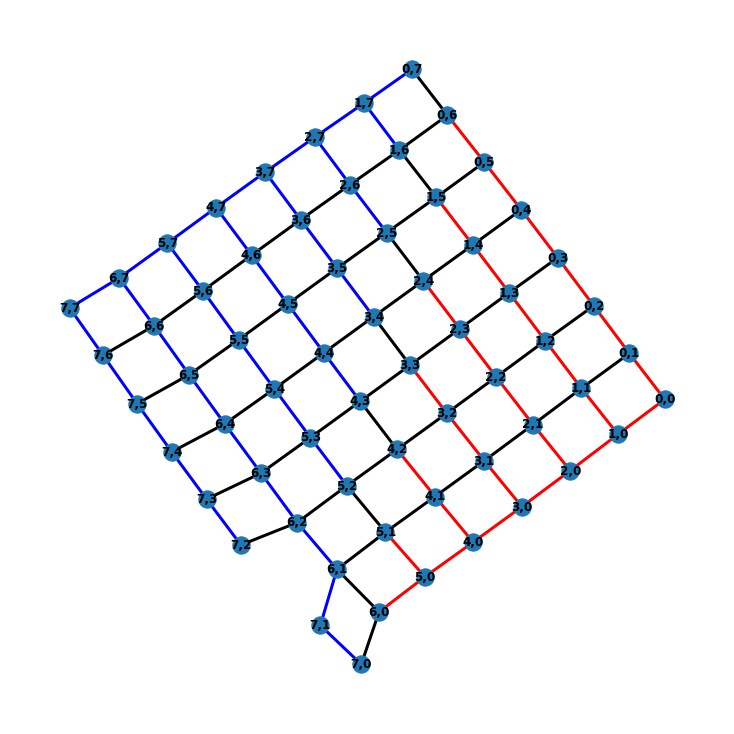

In [221]:
fig = plt.figure(figsize=(10,10))
G_draw = G.copy()
nx.set_edge_attributes(G_draw, 1, "weight")
nx.draw_kamada_kawai(G_draw, edge_color = nx.get_edge_attributes(G,'color').values(), width=3, with_labels=True, font_weight='bold')

In [222]:
n1, n2 = grow(G,A)
path1, maxflow1 = get_path_flow(G,n1)
path2, maxflow2 = get_path_flow(G,n2)
print(path1[::-1]+path2, min(maxflow1, maxflow2))
O = augment(G,path1[::-1]+path2,min(maxflow1, maxflow2, G[n1][n2]['weight']))
print(O)
adopt(G,O,A)

['0,0', '1,0', '2,0', '3,0', '4,0', '5,0', '5,1', '6,1', '6,2', '6,3', '6,4', '6,5', '6,6', '6,7', '7,7'] 0.6487212707001282
['5,0']
